In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:6], len(words)

(['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte'], 32033)

In [3]:
letters = sorted(list(set("".join(words))))
ltoi = { l:i + 1 for i,l in enumerate(letters)}
ltoi["."] = 0
itol = { i+1:l for i,l in enumerate(letters)}
itol[0] = "."

In [24]:
block_size = 3;

def bulid_dataset(words, show_steps = False):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for l in w + ".":
            idx = ltoi[l]
            X.append(context)
            Y.append(idx)
            
            if(show_steps):
                print(''.join(itol[i] for i in context), '--->', itol[idx])
            context = context[1:] + [idx]
    return torch.tensor(X), torch.tensor(Y)

Xsample, Ysample = bulid_dataset(words[:1])

import random
random.seed(42)
random.shuffle(words)

# train => 80%, validation => 10%, test => 10% 
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

Xtr    , Ytr = bulid_dataset(words[ : n1])
Xval   , Yval  = bulid_dataset(words[n1 : n2])
Xtest  , Ytest = bulid_dataset(words[n2 : ])
print("train : ", len(Xtrain))
print("val : ", len(Xval))
print("test: ", len(Xtest))

train :  182437
val :  22836
test:  22886


In [25]:
# hyper parameters
n_embd    = 10  # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

letters_len = len(ltoi) # 27
g  = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((letters_len       , n_embd)        , generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden)     , generator=g) * (5/3) / ((n_embd * block_size)**0.5) # kaiming init
# b1 = torch.randn(n_hidden                           , generator=g) # using batchNorm instead which has 'n_bias'
W2 = torch.randn((n_hidden          , letters_len)  , generator=g)
b2 = torch.randn(letters_len                        , generator=g)

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [27]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi  = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  

      0/ 200000: 2.8229
  10000/ 200000: 2.2656
  20000/ 200000: 2.3156
  30000/ 200000: 2.7965
  40000/ 200000: 2.3017
  50000/ 200000: 2.5730
  60000/ 200000: 2.1295
  70000/ 200000: 2.3226
  80000/ 200000: 2.3636
  90000/ 200000: 2.5589
 100000/ 200000: 2.2046
 110000/ 200000: 2.1988
 120000/ 200000: 2.3413
 130000/ 200000: 1.9753
 140000/ 200000: 2.2377
 150000/ 200000: 2.2994
 160000/ 200000: 2.0209
 170000/ 200000: 2.2956
 180000/ 200000: 2.3615
 190000/ 200000: 2.3027


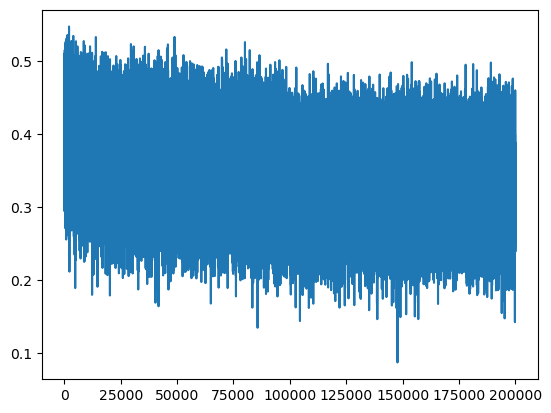

In [28]:
plt.plot(lossi)

In [29]:
# instead of calculating in the runtime (bnmean_running, bnstd_running) we can do it at the end
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [32]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xval, Yval),
    'test': (Xtest, Ytest),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, letters_len)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.132131338119507
val 2.1655619144439697


In [33]:
# SUMMARY + PYTORCHIFYING ----------- buliding like pytorch api

In [35]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((letters_len, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, letters_len, bias=False), BatchNorm1d(letters_len),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, letters_len),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [36]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2703


layer 2 (      Tanh): mean -0.01, std 0.64, saturated: 2.66%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 2.62%
layer 8 (      Tanh): mean -0.00, std 0.65, saturated: 2.28%
layer 11 (      Tanh): mean -0.00, std 0.65, saturated: 1.84%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.38%


Text(0.5, 1.0, 'activation distribution')

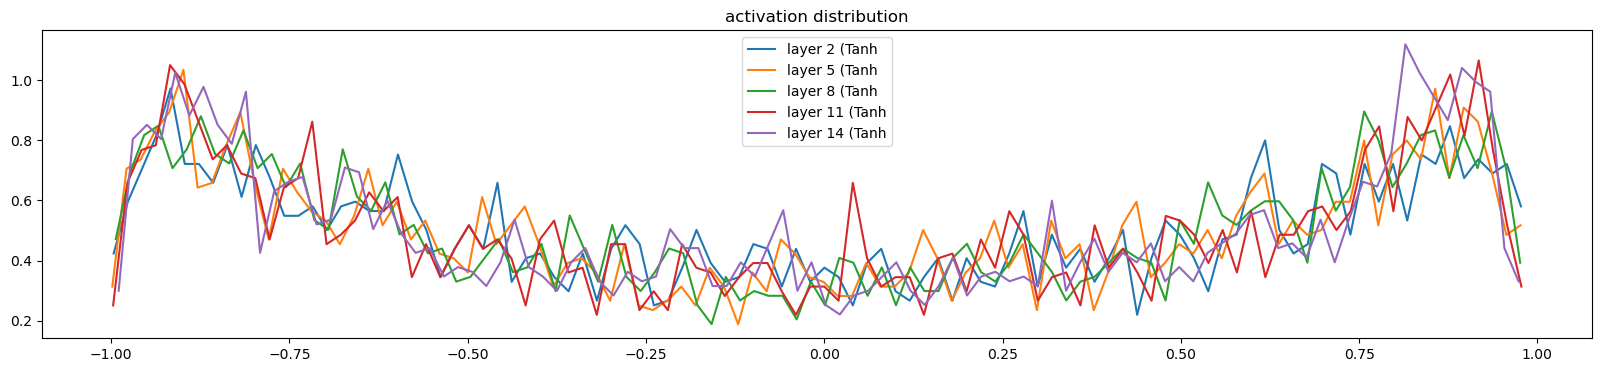

In [37]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 2.507167e-03
layer 5 (      Tanh): mean +0.000000, std 2.102328e-03
layer 8 (      Tanh): mean -0.000000, std 1.869892e-03
layer 11 (      Tanh): mean +0.000000, std 1.744264e-03
layer 14 (      Tanh): mean +0.000000, std 1.781717e-03


Text(0.5, 1.0, 'gradient distribution')

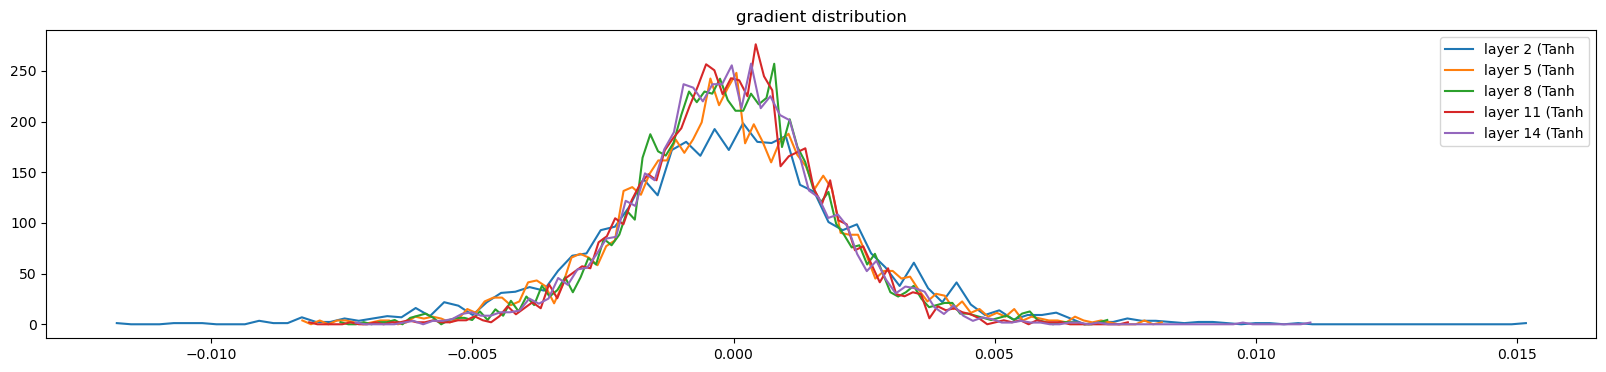

In [38]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 6.970477e-03 | grad:data ratio 6.963596e-03
weight  (30, 100) | mean -0.000018 | std 9.403409e-03 | grad:data ratio 4.965913e-02
weight (100, 100) | mean -0.000047 | std 6.915612e-03 | grad:data ratio 6.758422e-02
weight (100, 100) | mean -0.000027 | std 5.743905e-03 | grad:data ratio 5.597943e-02
weight (100, 100) | mean -0.000014 | std 5.130170e-03 | grad:data ratio 5.035949e-02
weight (100, 100) | mean -0.000062 | std 5.187890e-03 | grad:data ratio 5.100707e-02
weight  (100, 27) | mean -0.000245 | std 1.065041e-02 | grad:data ratio 1.024339e-01


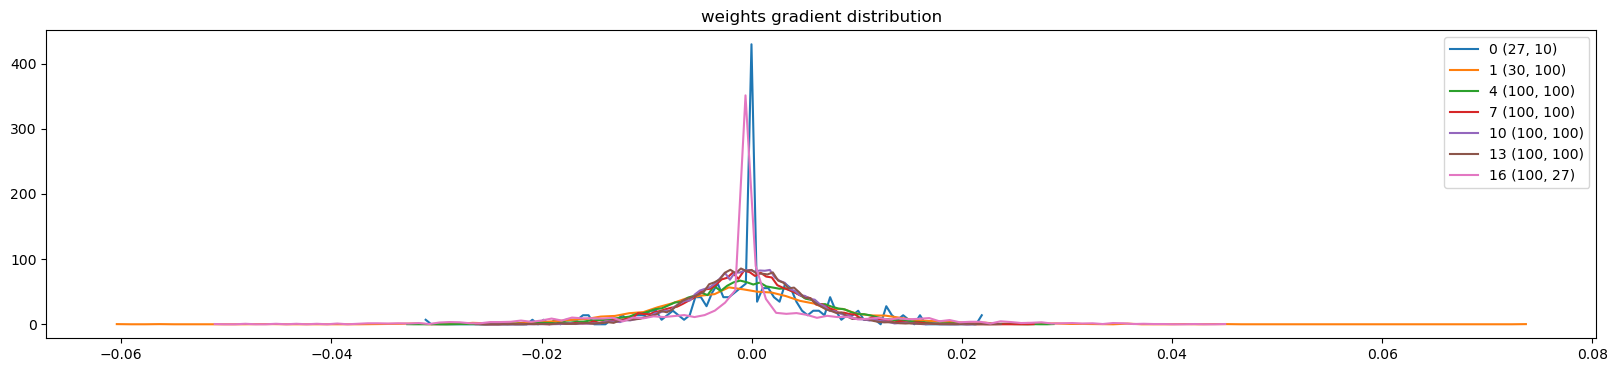

In [39]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

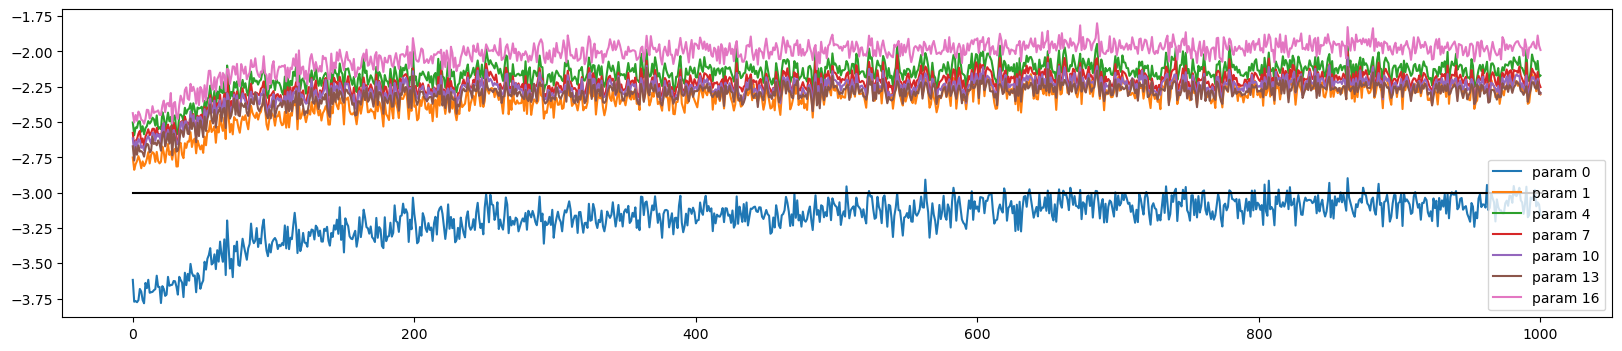

In [40]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


In [42]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xval, Yval),
    'test': (Xtest, Ytest),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.3917691707611084
val 2.4058585166931152


In [44]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itol[i] for i in out)) # decode and print the generated word

erianimyan.
seel.
ndhn.
alarethrstendrlen.
aderedieli.
jemi.
jen.
ekennesoraarielynioh.
kaa.
noshdbergshiries.
kin.
renelelxnterofiu.
zaneder.
yarle.
ehs.
kayja.
shalanihalina.
yansuf.
zajelveu.
ena.
